In [48]:
#########################################################################
############     FUNCTION LIBRARY FOR VARIOUS PURPOSES   ################
#########################################################################

import re
import os
import math
import pylab
import imageio
import calendar
import random as rand
import numpy as np
import pandas as pandas
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import matplotlib.cm as cm
import scipy.optimize as sciop
import scipy as spy
import scipy.signal

from scipy.optimize import curve_fit
from scipy.special  import wofz
from scipy.signal import savgol_filter
from scipy import ndimage, misc
from decimal import Decimal
from os import listdir
from os.path import isfile, join
from numpy.fft import *
from mpl_toolkits.mplot3d import Axes3D
from astropy.io import fits # this is for EMCCD fits files read in
from matplotlib.patches import Circle
from tqdm import tqdm


########################     Data Binning   ########################
####################################################################

def data_binning(xdata,ydata,binnum):
    """ this returns the binned xdata, ydata, std """
    bins = np.linspace(min(xdata), max(xdata), binnum)+(xdata[1]-xdata[0])/2
    binned_depl=[]
    binned_depl_std=[]
    depl_np_array=np.array(ydata)
    for i in range(len(bins)-1):
        binpoints=[j for j,v in enumerate(xdata) if (v>=bins[i] and v <= bins[i+1])]
        binned_depl.append(np.mean(depl_np_array[binpoints]))
        binned_depl_std.append(np.std(depl_np_array[binpoints])/np.sqrt(len(binpoints)))
    return[np.array(bins[:-1]),np.array(binned_depl),np.array(binned_depl_std)]

def tof_binning(xdata,ydata,tstep):
    """ this returns the binned xdata, ydata, std """
    bins = np.linspace(min(xdata), max(xdata), int((max(xdata)-min(xdata))/tstep))+(xdata[1]-xdata[0])/2
    binned_depl=[]
    binned_depl_std=[]
    depl_np_array=np.array(ydata)
    for i in range(len(bins)-1):
        binpoints=[j for j,v in enumerate(xdata) if (v>=bins[i] and v <= bins[i+1])]
        binned_depl.append(np.mean(depl_np_array[binpoints]))
        binned_depl_std.append(np.std(depl_np_array[binpoints])/np.sqrt(len(binpoints)))
    return[np.array(bins[:-1]),np.array(binned_depl),np.array(binned_depl_std)]

def data_binning_add(xdata,ydata,binnum):
    """ this function bins the data and keeps the integration area the same"""
    bins = np.linspace(min(xdata), max(xdata), binnum)+(xdata[1]-xdata[0])/2
    binned_depl=[]
    binned_depl_std=[]
    depl_np_array=np.array(ydata)
    for i in range(len(bins)-1):
        binpoints=[j for j,v in enumerate(xdata) if (v>=bins[i] and v <= bins[i+1])]
        binned_depl.append(np.sum(depl_np_array[binpoints]))
    return[np.array(bins[:-1]),np.array(binned_depl)]


def data_reduce_common_x(xdata,ydata):
    """ this returns the xdata, ydata, std """
    d={}
    xbin=[]
    ybin=[]
    error=[]
    for a, b in zip(xdata, ydata):
        d.setdefault(a, []).append(b)
    for key in d:
        a,b,c = key, sum(d[key])/len(d[key]), np.std(d[key])/np.sqrt(len(d[key]))
        xbin.append(a)
        ybin.append(b)
        if c>.0001:
            error.append(c)
        else:
            error.append(.1)
    return[np.array(xbin),np.array(ybin),np.array(error)]


def dat_smooth(x,window_len=11,window='hanning'):
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    y=np.convolve(w/w.sum(),s,mode='valid')
    return np.array(y[int(np.floor(window_len/2)):-int(np.floor(window_len/2)-1)])

    
def smooth(x,window_len=11,window='hanning'):
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    y=np.convolve(w/w.sum(),s,mode='valid')
    return np.array(y)
    
    
########################     Time of Flight Related   ########################
##############################################################################

def tof_cut(xdat,ydat,tmin,tmax):
    """ xdat is the time axis, should use the same unit with tmin and tmax"""
    idxmin=(np.abs(xdat-tmin)).argmin()
    idxmax=(np.abs(xdat-tmax)).argmin()
    xdatstar=xdat[idxmin:idxmax]
    ydatstar=ydat[idxmin:idxmax]
    return(xdatstar,ydatstar)

def tof_back_norm(xdat,ydat,tstar):
    """ this code is not currently being used in any function """
    idxstar=(np.abs(xdat-tstar)).argmin()
    blevel=np.mean(ydat[-idxstar:])
    ydat=np.subtract(ydat,np.mean(ydat[-idxstar:]))
    ydat=np.divide(ydat,blevel)
    return(xdat,ydat)


def bgnd_subtract_tof(xdat,ydat,tstar):
    """ if you see "np.mean(ydat[idxstar:])" it means tstar is the start point of background counts; if you see a minus sign inside, it means tstar is the duration of background counts """
    idxstar=(np.abs(xdat-tstar)).argmin()
    ydat=np.subtract(ydat,np.mean(ydat[idxstar:]))
    return(xdat,ydat)

def bgnd_subtract_general(xdat,ydat,tstar):
    idxstar=(np.abs(xdat-tstar)).argmin()
    bg = np.mean(ydat[idxstar:])
    ydat=np.subtract(ydat,np.mean(ydat[idxstar:]))
    return(xdat,ydat,bg)

def bgnd_subtract_general_regional(xdat,ydat,tstar,tend):
    idxstar=(np.abs(xdat-tstar)).argmin()
    idxend=(np.abs(xdat-tend)).argmin()
    bg = np.mean(ydat[idxstar:idxend])
    ydat=np.subtract(ydat,np.mean(ydat[idxstar:idxend]))
    return(xdat,ydat,bg)


def bgnd_subtract_abs(xdat,ydat,tstar):
    """ if you see "np.mean(ydat[idxstar:])" it means tstar is the start point of background counts; if you see a minus sign inside, it means tstar is the duration of background counts """
    # note that it returns the absorption ratio, which is the normalized data, not only background subtraction.
    idxstar=(np.abs(xdat-tstar)).argmin()
    dc=np.mean(ydat[idxstar:])
    ydat=np.subtract(ydat,dc)
    ydat=np.divide(ydat,dc)
    return(xdat,ydat)


def integrated_signal(TOF_vec):
    """ it returns the sum of TOF """
    out=[]
    n=len(TOF_vec)
    for i in range(n):
        out.append(np.sum(TOF_vec[i]))
    return(out)

def avg_TOF_dist(filename,PMT_Select):
    onlyfiles = [f for f in listdir(filename) if isfile(join(filename, f))]
    onlycts=[x for x in onlyfiles if 'cts' in x]
    APi_Status=[]
    ctstime=[]
    cts1on=[]
    cts2on=[]
    cts1off=[]
    cts2off=[]
    for j in range(len(onlycts)):
        words=onlycts[j].split('_')
        APi_Status.append(int(words[-1][:-4]) % 2)
    for j in range(len(onlycts)):
        if APi_Status[j]==1:
            ctstime.append(np.genfromtxt(filename+onlycts[j])[:,0])
            cts1on.append(np.genfromtxt(filename+onlycts[j])[:,1])
            cts2on.append(np.genfromtxt(filename+onlycts[j])[:,3])
            col_totals1on = [ sum(x) for x in zip(*cts1on) ]
            col_totals2on = [ sum(x) for x in zip(*cts2on) ]
        if APi_Status[j]==0:
            cts1off.append(np.genfromtxt(filename+onlycts[j])[:,1])
            cts2off.append(np.genfromtxt(filename+onlycts[j])[:,3])
            col_totals1off = [ sum(x) for x in zip(*cts1off) ]
            col_totals2off = [ sum(x) for x in zip(*cts2off) ]
    ctstime1=ctstime[0]
    if PMT_Select==1:
        col1=np.divide(col_totals1on,len(onlycts)/2)
        col2=np.divide(col_totals1off,len(onlycts)/2)
    else:
        col1=np.divide(col_totals2on,len(onlycts)/2)
        col2=np.divide(col_totals2off,len(onlycts)/2)
    return(ctstime1,col1,col2)


def pull_tof_signal(filename):
    onlyfiles = [f for f in listdir(filename) if isfile(join(filename, f))]
    onlycts=[x for x in onlyfiles if 'cts' in x]
    var_raw=[]
    ctstime=[]
    ctsnvar=[]
    cts1=[]
    cts1var=[]
    cts2var=[]
    cts2=[]
    shot_index=[]
    shot_index1=[]
    for j in range(len(onlycts)):
        words=onlycts[j].split('_')
        var_raw.append(float(words[-2]))
        shot_index.append(int(words[-1][:-4]))
    for j in range(len(onlycts)):
        ctstime.append(np.genfromtxt(filename+onlycts[j])[:,0])
        cts1.append(np.genfromtxt(filename+onlycts[j])[:,1])
        cts2.append(np.genfromtxt(filename+onlycts[j])[:,3])
        cts1var.append(var_raw[j])
        cts2var.append(var_raw[j])
        shot_index1.append(shot_index[j])
    sort_table=np.argsort(shot_index1)
    cts1var=np.array(cts1var)[sort_table]
    cts1=np.array(cts1)[sort_table]
    shot_index1=np.array(shot_index1)[sort_table]
    cts2var=np.array(cts2var)[sort_table]
    cts2=np.array(cts2)[sort_table]
    ctstime1=ctstime[0]
    return(ctstime1,[cts1var,cts1,shot_index1],[cts2var,cts2])


def pull_abs_signal(filename):
    onlyfiles = [f for f in listdir(filename) if isfile(join(filename, f))]
    onlyabs=[x for x in onlyfiles if 'cts' not in x and 'desktop' not in x and 'asc' not in x and 'fits' not in x and 'parameters' not in x]
    var_raw=[]
    abstime=[]
    absnvar=[]
    abs1=[]
    abs1var=[]
    abs2var=[]
    abs2=[]
    shot_index=[]
    shot_index1=[]
    for j in range(len(onlyabs)):
        words=onlyabs[j].split('_')
        var_raw.append(float(words[-2]))
        shot_index.append(int(words[-1][:-4]))
    for j in range(len(onlyabs)):
        abstime.append(np.genfromtxt(filename+onlyabs[j])[:,0])
        abs1.append(np.genfromtxt(filename+onlyabs[j])[:,1])
        abs2.append(np.genfromtxt(filename+onlyabs[j])[:,3])
        abs1var.append(var_raw[j])
        abs2var.append(var_raw[j])
        shot_index1.append(shot_index[j])
    sort_table=np.argsort(shot_index1)
    abs1var=np.array(abs1var)[sort_table]
    abs1=np.array(abs1)[sort_table]
    shot_index1=np.array(shot_index1)[sort_table]
    abs2var=np.array(abs2var)[sort_table]
    abs2=np.array(abs2)[sort_table]
    abstime1=abstime[0]
    return(abstime1,[abs1var,abs1,shot_index1],[abs2var,abs2])

def pull_abs_signal_3ch(filename):
    onlyfiles = [f for f in listdir(filename) if isfile(join(filename, f))]
    onlyabs=[x for x in onlyfiles if 'cts' not in x and 'desktop' not in x and 'asc' not in x and 'fits' not in x and 'parameters' not in x]
    var_raw=[]
    abstime=[]
    absnvar=[]
    abs1=[]
    abs1var=[]
    abs2var=[]
    abs2=[]
    abs3=[]
    abs3var=[]
    shot_index=[]
    shot_index1=[]
    for j in range(len(onlyabs)):
        words=onlyabs[j].split('_')
        var_raw.append(float(words[-2]))
        shot_index.append(int(words[-1][:-4]))
    for j in range(len(onlyabs)):
        abstime.append(np.genfromtxt(filename+onlyabs[j])[:,0])
        abs1.append(np.genfromtxt(filename+onlyabs[j])[:,1])
        abs2.append(np.genfromtxt(filename+onlyabs[j])[:,3])
        abs3.append(np.genfromtxt(filename+onlyabs[j])[:,5])
        abs1var.append(var_raw[j])
        abs2var.append(var_raw[j])
        abs3var.append(var_raw[j])
        shot_index1.append(shot_index[j])
    sort_table=np.argsort(shot_index1)
    abs1var=np.array(abs1var)[sort_table]
    abs1=np.array(abs1)[sort_table]
    shot_index1=np.array(shot_index1)[sort_table]
    abs2var=np.array(abs2var)[sort_table]
    abs2=np.array(abs2)[sort_table]
    abs3var=np.array(abs3var)[sort_table]
    abs3=np.array(abs3)[sort_table]
    abstime1=abstime[0]
    return(abstime1,[abs1var,abs1,shot_index1],[abs2var,abs2],[abs3var,abs3])


def TOF_Process(filename,tmin,tmax,t_back,filter_dist=1,PMTnum=1):
    hold=pull_tof_signal(filename)
    Api_off=[]
    Api_off_var=[]
    Api_off_int=[]
    Api_off_index=[]
    length=np.min([len(hold[2][1]),len(hold[1][1])])
    for i in range(length):
        holder=hold[PMTnum][1][i]
        [time,holder]=bgnd_subtract_tof(hold[0],holder,t_back)
        [time,holder]=tof_cut(hold[0],holder,tmin,tmax)
        weighted_dist=holder
        Api_off_int.append(np.sum(weighted_dist))
        Api_off_var.append(hold[2][0][i])
    return(np.array(Api_off_var),np.array(Api_off_int))

def TOF_Process_werr(filename,tmin,tmax,t_back,filter_dist=1,PMTnum=1,bgmiddle=False):
    hold=pull_tof_signal(filename)
    Api_off=[]
    Api_off_var=[]
    Api_off_int=[]
    Api_off_index=[]
    Api_off_err=[]
    length=np.min([len(hold[2][1]),len(hold[1][1])])
    for i in range(length):
        holder=hold[PMTnum][1][i]
        if bgmiddle == False:
            [time,holder]=bgnd_subtract_tof(hold[0],holder,t_back)
        else:
            idx1=(np.abs(hold[0]-10E3)).argmin()
            idx2=(np.abs(hold[0]-20E3)).argmin()
            time, holder = hold[0], holder-np.mean(holder[idx1:idx2])
        tlength=int((tmax-tmin)/(time[1]-time[0]))
        Api_off_err.append(np.sum(holder[-tlength:]))
        
        [time,holder]=tof_cut(hold[0],holder,tmin,tmax)
        weighted_dist=holder
        Api_off_int.append(np.sum(weighted_dist))
        Api_off_var.append(hold[2][0][i])
    return(Api_off_var,Api_off_int,Api_off_err)

def Abs_rel_int(filename, tmin, tmax, tback, pdnum=1, darkc=0, bgtime = 'late', gettrace=False):
    if pdnum>2:
        [abstime,[var1,abs1,index],[var2,abs2],[var3,abs3]]=pull_abs_signal_3ch(filename)
        abs1 = abs3-darkc
    else:
        [abstime,[var1,abs1,index],[var2,abs2]]=pull_abs_signal(filename)
        if pdnum==1:
            abs1 = abs1-darkc
        else:
            abs1 = abs2-darkc
    rel_abs = []
    rel_abs_var = []
    length = len(var1)
    trace_store = []
    for i in range(length):
        holder = abs1[i]
        if bgtime == 'early':
            bg = np.mean(holder[0:140])
        else:
            idxstar=(np.abs(abstime-tback)).argmin()
            bg = np.mean(holder[idxstar:])
        holder = -holder+bg
        holder = holder/bg
        [_,holder_cut]=tof_cut(abstime,holder,tmin,tmax)
        rel_abs.append(np.mean(holder_cut))
        rel_abs_var.append(var1[i])
        trace_store.append(holder)
    if gettrace == True:
        return np.array(rel_abs_var), np.array(rel_abs), np.array(abstime), np.array(trace_store)
    else:
        return np.array(rel_abs_var), np.array(rel_abs)

    
def Abs_int(filename, tmin, tmax, tback, pdnum=1, bgtime = 'late', gettrace=False):
    if pdnum>2:
        [abstime,[var1,abs1,index],[var2,abs2],[var3,abs3]]=pull_abs_signal_3ch(filename)
        abs1 = abs3
    else:
        [abstime,[var1,abs1,index],[var2,abs2]]=pull_abs_signal(filename)
        if pdnum==1:
            abs1 = abs1
        else:
            abs1 = abs2
    rel_abs = []
    rel_abs_var = []
    length = len(var1)
    trace_store = []
    for i in range(length):
        holder = abs1[i]
        if bgtime == 'early':
            bg = np.mean(holder[0:140])
        else:
            idxstar=(np.abs(abstime-tback)).argmin()
            bg = np.mean(holder[idxstar:])
        holder = -holder+bg
        [_,holder_cut]=tof_cut(abstime,holder,tmin,tmax)
        rel_abs.append(np.mean(holder_cut))
        rel_abs_var.append(var1[i])
        trace_store.append(holder)
    if gettrace == True:
        return np.array(rel_abs_var), np.array(rel_abs), np.array(abstime), np.array(trace_store)
    else:
        return np.array(rel_abs_var), np.array(rel_abs)
    

def Abs_Process(filename,tmin,tmax,t_stop, t_back,filter_dist=1,PMTnum=1,darkc=0):
    hold=pull_abs_signal(filename) # make a matrix with the raw data
    Api_off=[]
    Api_off_var=[]
    Api_off_int=[]
    Api_off_index=[]
    length=np.min([len(hold[2][1]),len(hold[1][1])]) # find the minimum length between time and signal 
    for i in range(length):
        holder=hold[PMTnum][1][i] #creates vector of signal from the specified PMT TOF signal
        holder=np.subtract(holder,darkc) #subtracts the dark counts from the TOF signal
        [time,holder]=bgnd_subtract_abs(hold[0],holder,t_back) #subtracts DC avg background from signal vecto
        [time,holder]=tof_cut(hold[0],holder,tmin,tmax) #outputs trimmed t and signal vectors
        weighted_dist=np.multiply(holder,-1) # defines weighted dist vector filled with negative of the t and signal vects
        weighted_dist=holder # defines weighted dist vector filled with the t and signal vects (undoes line above?)
        Api_off_int.append(np.sum(weighted_dist)) # appends the vectors with the integrated signal
        Api_off_var.append(hold[2][0][i]) # appends the vectors definied at the begining of the function with the frequency 
    return(Api_off_var,Api_off_int) #returns vectors of the frequencies and integrates TOF signals


def get_PMT_signal(filename,PMT_select=1,variable=None,onoff=False,bgsub=True):
    [ctstime,[var1,ct1,index],[var2,ct2]]=pull_tof_signal(filename)
    if PMT_select != 1:
        ct1 = ct2
    if variable==None:
        variable = var1[0]
        cts=ct1
    else:
        cts=ct1[var1==variable]
    cts_even = cts[0::2]
    cts_odd = cts[1::2]
    col_total = np.array([ sum(x) for x in zip(*cts) ])/len(cts)
    col_even = np.array([ sum(x) for x in zip(*cts_even) ])/len(cts_even)
    col_odd = np.array([ sum(x) for x in zip(*cts_odd) ])/len(cts_odd)
    if bgsub == True:
        col_total -= np.mean(col_total[int(len(col_total)*0.25):])
        col_even -= np.mean(col_even[int(len(col_even)*0.25):])
        col_odd -= np.mean(col_odd[int(len(col_odd)*0.25):])
    if onoff == True:
        if max(col_odd) > max(col_even):
            col_big = col_odd
            col_small = col_even
        else:
            col_big = col_even
            col_small = col_odd
        return np.array(ctstime), col_big, col_small
    else:
        return np.array(ctstime), col_total
    

########################     Alternating Data    ########################
#########################################################################


def Alternating_APi_Depletion_Combined(filename,tmin,tmax,tback,PMT_Select=1):
    tester=TOF_Process(filename,tmin,tmax,tback,PMTnum=PMT_Select)
    xd=tester[0]
    yf=tester[1]
    xd=xd[1::2]
    odds=yf[1::2]
    evens=yf[0::2]
    oddnum=np.mean(odds)
    odderr=np.std(odds)/np.sqrt(len(odds))
    evennum=np.mean(evens)
    evenerr=np.std(evens)/np.sqrt(len(evens))
    if oddnum>evennum:
        offnum=oddnum
        offerr=odderr
        onnum=evennum
        onerr=evenerr
    else:
        onnum=oddnum
        onerr=odderr
        offnum=evennum
        offerr=evenerr
    return([onnum,onerr],[offnum,offerr])


def Alternating_APi_Depletion(filename, tmin, tmax, tback, PMT_Select=1):
    tester=TOF_Process(filename,tmin,tmax,tback,PMTnum=PMT_Select)
    xd=tester[0]
    yf=tester[1]
    xdodd=xd[1::2]
    odds=yf[1::2]
    xdeven=xd[0::2]
    evens=yf[0::2]
    maxn=min(len(evens),len(odds))
    if np.mean(odds)>np.mean(evens):
        offnum=np.array(odds[0:maxn])
        onnum=np.array(evens[0:maxn])
        variable=np.array(xdeven[0:maxn])
    else:
        onnum=np.array(odds[0:maxn])
        offnum=np.array(evens[0:maxn])
        variable=np.array(xdodd[0:maxn])
    return([variable,onnum, offnum])



########################     Physics Analysis    ########################
#########################################################################

def expo_decay_from_1_with_offset(t, r, off):
    return (1-off)*np.exp(-r*t)+off

def Dop_Line_Shape(v,vo,width):
    hold = (2/width)*(np.sqrt((np.log(2))/(np.pi)))*(np.exp(-4*np.log(2)((v-vo)/(width))**2))
    return hold

def gaussian(x,aa,bb,cc,dd):
    hold=aa+bb*np.exp(-(x-cc)**2/dd**2)
    return hold

def double_related_gaussian(x,aa,bb,cc,dd):
    hold=aa+0.5*bb*np.exp(-(x-cc+12)**2/dd**2)+bb*np.exp(-(x-cc)**2/dd**2)
    return hold

def triple_related_gaussian(x,aa,bb,cc,dd):
    hold=aa+bb*np.exp(-(x-cc)**2/dd**2)+(2/3)*bb*np.exp(-(x-cc-20)**2/dd**2)+(1/3)*bb*np.exp(-(x-cc-32)**2/dd**2)
    return hold

def double_gaussian(x, a, b1, c1, d1, b2, c2, d2):
    hold=a+b1*np.exp(-(x-c1)**2/d1**2)+b2*np.exp(-(x-c2)**2/d2**2)
    return hold

def gaussian_null(x,aa,bb,cc,dd):
#     hold=aa+bb*np.exp(-(x-cc)**2/(2*dd**2))
    hold=0*aa+bb*np.exp((-4)*(np.log(2))*((x-cc)**2)/(dd**2))
    return hold

def gaussian_no_off(x,aa,bb,cc,dd):
    hold=aa*0+bb*np.exp(-1*(x-cc)**2/(2*dd**2))
    return hold

def dop_gaussian(x,aa,cc,dd):
    hold=aa+(2/dd)*(np.sqrt((np.log(2))/(np.pi)))*np.exp(-4*(np.log(2))*(x-cc)**2/(dd**2))
    return hold

# def lorentzian(x,xc,w):
#     return 2*w/(np.pi*4*(x-xc)*(x-xc)+w*w)

def lorentzian(x,xc,w,a):
    return a/(1+((x-xc)/(w/2))**2)

def lam_to_f(lam_data):
    c=299792458
    fdata=np.divide(c,np.multiply(lam_data,1E-9))
    return(fdata)

def normalized(data):
    return(data/max(data))

def Build_filters(filename,tmin,tmax,tback,smooth,tzero):
    avg_hold=avg_dist_alt(filename)
    [time_avg,Api_off_avg]=tof_cut(avg_hold[0],avg_hold[1],tmin,tmax)
    [time_avg,Api_on_avg]=tof_cut(avg_hold[0],avg_hold[2],tmin,tmax)
    [time_avg,Api_off_avg]=bgnd_subtract_tof(time_avg,Api_off_avg,tback)
    [time_avg,Api_on_avg]=bgnd_subtract_tof(time_avg,Api_on_avg,tback)
    vel_filter=np.subtract(Api_on_avg,Api_off_avg)/max(np.subtract(Api_on_avg,Api_off_avg))
    vel_filter=smooth(vel_filter,smooth)
    vel_filter[-tzero:]=0
    return(vel_filter)


def calc_mol_numb(file,vo,dop_width_MHz,t_min,t_max,t_back):
    cell_length = 2.54 #in cm
    cell_radius= (1.25/2)*2.54 #in cm
    cell_vol = np.pi*(cell_radius**2)*cell_length #in cm^3
    Nat_Linewidth_Mhz = 6
    dop_width_MHz = dop_width_MHz
    res_freq_Hz = center*(1e12)
    [time,[var,abs1,index],[var2,abs2]]=pull_abs_signal(file)
    TOF = abs2[10]
    Time = var2[10]
    delta_t = time[2]-time[1]
    min_t_index = t_min*(1/delta_t)
    max_t_index = t_max*(1/delta_t)
    TOF_Size = np.size(TOF)
    I_Bkg = np.average(TOF[tback:TOF_Size])
    I_Min = min(TOF[min_t_index:max_t_index])
    wavelength = C/res_freq_Hz*100 #wavelength in cm
    res_crossec = (wavelength**2)/(2*np.pi)
    dop_crossec = (res_crossec*Nat_Linewidth_Mhz*np.pi)/(dop_width_MHz*np.sqrt(2))
    beam_radius = 0.001
    percent_abs = 100*(I_Bkg-I_Min)/I_Bkg
    mol_density = (I_Bkg-I_Min)/(I_Bkg*dop_crossec*cell_length)
    mol_num = mol_density*cell_vol #naive way of calc N
    return mol_num,percent_abs


########################     EMCCD related    ########################
######################################################################

def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)',text) ]

def import_img(filename, N_switch = 1):
    onlyfiles = [f for f in listdir(filename) if isfile(join(filename, f))]
    onlyimg=[x for x in onlyfiles if 'fits' in x]
    onlyimg.sort(key=natural_keys) # this is to sort the files in human sorting way instead of using alphabatical
    Img = []
    for i in range(len(onlyimg)):
        with fits.open(filename+onlyimg[i]) as hdul:
            Img.append(hdul[0].data[0])
    nimg = len(Img)
    nimg_eff = N_switch * (nimg // N_switch)
    if nimg_eff != nimg:
        Img = Img[0:nimg_eff]
        print('some groups are incomplete')
    if int(re.split('(\d+)',onlyimg[-1])[1]) != nimg:
        print('some data are missing')
#     print('images import done')
    return np.array(Img), nimg_eff

def display_CCD(img, style = '2D', center = (33, 33), center_plot = True, colorlim = None):
    """
    note: when displaying, Z needs to be transposed, such that the first 
    dimension of Z can be looked as x and second dimension can be trated as y.
    """
    x, y = np.arange(img.shape[0]), np.arange(img.shape[1])
    X, Y = np.meshgrid(x, y)
    Z = img
    if style == '2D':
        fig, ax = plt.subplots(figsize=(5,4))
        if colorlim == None:
            tcf = ax.pcolormesh(X, Y, Z.T,cmap='inferno',shading='auto')
        else:
            tcf = ax.pcolormesh(X, Y, Z.T,cmap='inferno',shading='auto', vmin=colorlim[0], vmax=colorlim[1])
        fig.colorbar(tcf)
        if center_plot == True:
            circ = Circle(center, 5, facecolor='None', edgecolor='w', lw=3)
            ax.add_patch(circ)
            ax.scatter(list(center)[0],list(center)[1], linewidths = 5, c = 'w')
        plt.show()
    elif style == '3D':
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.plot_surface(X, Y, Z.T, cmap='plasma')
        ax.set_zlim(0,np.max(Z)+2)
        plt.show()
        
        
########################     Plotting Settings    ########################

font = {'size'   : 14}
plt.rc('font', **font)
plt.rcParams["font.family"] = "Arial"
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# Data Analysis

In [49]:
class Analyzer(object):
    def __init__(self, str_prefix, year=2023, month=2, date=14, filenum=1, group=1):
        str_month = str(month).zfill(2)+'-'+calendar.month_abbr[month]
        str_date =str(year)+'-'+str(month).zfill(2)+'-'+str(date).zfill(2)
        self.filename = str_prefix+str(year)+'\\'+str_month+'\\'+str_date+'\\'+str_date+'_Waveforms'+str(filenum)+'\\'
        self.group = group
    def read_analog(self):
        self.ana_time, [self.ana_var,self.ana1,self.ana_shot_index],[_,self.ana2],[_,self.ana3] = pull_abs_signal_3ch(self.filename)
        self.ana_time = self.ana_time * 1E3 - 1.66 #used to be 1.74 #convert time from s to ms and shift zero time
        self.ana_sig = [self.ana1, self.ana2, self.ana3]
    def read_counter(self):
        self.cnt_time, [self.cnt_var,self.cnt1,self.cnt_shot_index],[_,self.cnt2] = pull_tof_signal(self.filename)
        self.cnt_time = self.cnt_time * 1E-3 #convert time from us to ms
        self.cnt_sig = [self.cnt1, self.cnt2]
    def bgsub_analog(self, channel=0, bgstart=20, bgend=40):
        for temp in range(len(self.ana_sig[channel])):
            _,self.ana_sig[channel][temp],self.ana_bg = bgnd_subtract_general_regional(self.ana_time,self.ana_sig[channel][temp],bgstart,bgend)
    def bgsub_counter(self, channel=0, bgstart=20, bgend=30):
        for temp in range(len(self.cnt_sig[channel])):
            _,self.cnt_sig[channel][temp],self.cnt_bg = bgnd_subtract_general_regional(self.cnt_time,self.cnt_sig[channel][temp],bgstart,bgend)
    def integral_analog(self, channel=0, intstart=1, intend=10):
        idxmin=(np.abs(self.ana_time-intstart)).argmin()
        idxmax=(np.abs(self.ana_time-intend)).argmin()
        self.ana_int = []
        for temp in range(len(self.ana_sig[channel])):
            self.ana_int.append(np.sum(self.ana_sig[channel][temp][idxmin:idxmax]))
        self.ana_int = np.array(self.ana_int)
        self.ana_int_mean = np.mean(self.ana_int)
        self.ana_int_err = np.std(self.ana_int)/ np.sqrt(len(self.ana_int))
    def mean_analog(self, channel=0, intstart=1, intend=10):
        idxmin=(np.abs(self.ana_time-intstart)).argmin()
        idxmax=(np.abs(self.ana_time-intend)).argmin()
        self.ana_mean = []
        for temp in range(len(self.ana_sig[channel])):
            self.ana_mean.append(np.mean(self.ana_sig[channel][temp][idxmin:idxmax]))
        self.ana_mean = np.array(self.ana_mean)
        self.ana_mean_mean = np.mean(self.ana_mean)
        self.ana_mean_err = np.std(self.ana_mean)/ np.sqrt(len(self.ana_mean))
    def integral_counter(self, channel=0, intstart=1, intend=10):
        idxmin=(np.abs(self.cnt_time-intstart)).argmin()
        idxmax=(np.abs(self.cnt_time-intend)).argmin()
        self.cnt_int = []
        for temp in range(len(self.cnt_sig[channel])):
            self.cnt_int.append(np.sum(self.cnt_sig[channel][temp][idxmin:idxmax]))
        self.cnt_int = np.array(self.cnt_int)
        self.cnt_int_mean = np.mean(self.cnt_int)
        self.cnt_int_err = np.std(self.cnt_int)/ np.sqrt(len(self.cnt_int))
    def meantof_analog(self, channel=0, plot=False, smooth = 2):
        self.ana_meantof = np.mean(self.ana_sig[channel],axis=0)
        if plot==True:
#             f, ax = plt.subplots(figsize=(6,4))
            for temp in range(self.group):
#                 ax.plot(self.ana_time, dat_smooth(np.mean(self.ana_sig[channel][temp::self.group],axis=0),window_len=smooth,window='hanning'), label=str(temp))
#                 ax.plot(self.ana_time, np.mean(self.ana_sig[channel][temp::self.group],axis=0), label=str(temp))
                plt.plot(self.ana_time, np.mean(self.ana_sig[channel][temp::self.group],axis=0), label=str(temp))
            plt.legend()
            plt.xlabel('time (ms)')
            plt.ylabel('signal (arb.)')
#             plt.xlim([0,3])
#             plt.show()
    def meantof_counter(self, channel=0, plot=False, smooth = 2):
        self.cnt_meantof = np.mean(self.cnt_sig[channel],axis=0)
        if plot==True:
            f, ax = plt.subplots(figsize=(6,4))
            for temp in range(self.group):
#                 ax.plot(self.cnt_time, dat_smooth(np.mean(self.cnt_sig[channel][temp::self.group],axis=0),window_len=smooth,window='hanning'), label=str(temp))
                ax.plot(self.cnt_time, np.mean(self.cnt_sig[channel][temp::self.group],axis=0), label=str(temp))
            plt.legend()
            plt.xlabel('time (ms)')
            plt.ylabel('signal (arb.)')
            plt.xlim([0,20])
            plt.show()
            
    ## images manipulation
    def read_EMCCD(self):
        self.img, self.img_n = import_img(self.filename, self.group)
    def rotation_EMCCD(self, angle = 0):
        self.img = np.array([ndimage.rotate(self.img[_], angle, reshape=False, cval = 0) for _ in range(len(self.img))])
    def integral_EMCCD(self, img_center = [33, 33], hor_window = 6, ver_window = 10):
        self.img_center = img_center
        self.img_hor_window = hor_window
        self.img_ver_window = ver_window
        temp = self.img[:,img_center[0]-int(hor_window/2):img_center[0]+int(hor_window/2),img_center[1]-int(ver_window/2):img_center[1]+int(ver_window/2)]
        int_sig = np.mean(temp,axis=(1,2))
        self.img_int = int_sig.reshape(self.img_n // self.group, self.group).T # img_int has shape of (N_switch, file num per stage)

    ## normalization with integrated values
    def norm_ana_by_cnt(self, ana_channel=2, cnt_channel=0):
        self.ana_int = self.ana_int / self.cnt_int
#         for temp in range(len(self.ana_sig[ana_channel])):
#             self.ana_sig[ana_channel][temp] = self.ana_sig[ana_channel][temp] / self.cnt_int[temp]
    def norm_cnt_by_ana(self, ana_channel=2, cnt_channel=0):
        self.cnt_int = self.cnt_int / self.ana_int
    def norm_cam_by_ana(self, ana_channel=2):
        self.img_int = self.img_int / self.ana_int.reshape(self.img_n // self.group, self.group).T    
    def cnt_ana_reshape(self):
        self.cnt_int = self.cnt_int.reshape(len(self.cnt_int) // self.group, self.group).T
        self.ana_int = self.ana_int.reshape(len(self.ana_int) // self.group, self.group).T
        
    def scattering_rate_meas(self, label_list, shot_per_state, plot = True, fit = True, ini_guess = [0.3, 0.1]):
        label_length = len(label_list)
        if self.group == 2:
            ratio = []
            ratio_err = []
            for index in range(label_length):
                ratios_temp = self.img_int[1,index*shot_per_state:(index+1)*shot_per_state] / self.img_int[0,index*shot_per_state:(index+1)*shot_per_state]
                ratio.append(np.mean(ratios_temp))
                ratio_err.append(np.std(ratios_temp)/np.sqrt(len(ratios_temp)))
            self.label_list, self.ratio, self.ratio_err = zip(*sorted(zip(label_list, ratio, ratio_err)))
            if plot == True:
                plt.errorbar(label_list, ratio, ratio_err,linestyle="",fmt='o',c=color,ms=10)
            if fit == True:
                fill=np.linspace(min(x),max(x),100)
                popt,pcov = curve_fit(expo_decay_from_1_with_offset, x, y, p0=ini_guess)
                perr = np.sqrt(np.diag(pcov))
                print(popt, perr)
                plt.plot(fill,expo_decay_from_1_with_offset(fill,*popt), label = 'fitted')

    def scattering_rate_meas_cnt(self, label_list, shot_per_state, plot = True, fit = True, ini_guess = [0.3, 0.1]):
        label_length = len(label_list)
        if self.group == 2:
            ratio = []
            ratio_err = []
            for index in range(label_length):
                ratios_temp = self.cnt_int[1,index*shot_per_state:(index+1)*shot_per_state] / self.cnt_int[0,index*shot_per_state:(index+1)*shot_per_state]
                ratio.append(np.mean(ratios_temp))
                ratio_err.append(np.std(ratios_temp)/np.sqrt(len(ratios_temp)))
            self.label_list, self.ratio, self.ratio_err = zip(*sorted(zip(label_list, ratio, ratio_err)))
            if plot == True:
                plt.errorbar(label_list, ratio, ratio_err,linestyle="",fmt='o',c='black',ms=10)
            if fit == True:
                x = np.array(label_list)
                y = np.array(ratio)
                fill=np.linspace(min(x),max(x),100)
                popt,pcov = curve_fit(expo_decay_from_1_with_offset, x, y, p0=ini_guess)
                perr = np.sqrt(np.diag(pcov))
                print(popt, perr)
                plt.plot(fill,expo_decay_from_1_with_offset(fill,*popt), label = 'fitted')
                

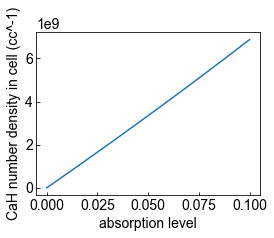

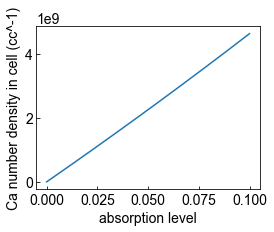

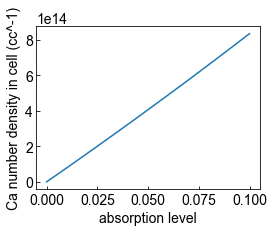

In [45]:
# CaH X-A absorption to density

import numpy as np
import matplotlib.pyplot as plt

e = 1.602E-19  #colomb
a = 1E-10    #meter
v = 431.275E12   #Hz, laser frequency
c = 299792458      #m/s
h = 6.626E-34  #Js
eps = 8.854E-12#F/m
sig = 3.14E-6#m^2, laser size
L = 0.0254   #m, laser propogation length
gamma = 4.8E6#Hz

def absToDensity(absCell):
    """ output in unit of cc^-1 """
    OD = -np.log10(1-absCell)
    n = OD * 2 * c * h * eps * gamma / L / v / (2*e*a)**2
    return n*1E-4 

absList = np.linspace(0, 0.1,10)
plt.figure(figsize = (4,3))
plt.plot(absList, absToDensity(absList))
plt.xlabel('absorption level')
plt.ylabel('CaH number density in cell (cc^-1)')
plt.show()

# Ca 423 absorption to density

def calcium423AbsToDensity(absCell):
    n = -np.log(1-absCell) / (423E-9)**2 * 2 / L
    return  n*1E-4 

absList = np.linspace(0, 0.1,10)
plt.figure(figsize = (4,3))
plt.plot(absList, calcium423AbsToDensity(absList))
plt.xlabel('absorption level')
plt.ylabel('Ca number density in cell (cc^-1)')
plt.show()


# Ca 657 absorption to density

P = 1e-3 # W
I = P / sig # W/m^2
gamma657 = 1e3 # Hz
Is = np.pi / 3 * h * c / (657e-9)**3 * gamma657

def calcium657AbsToDensity(absCell):
    n = -np.log(1-absCell) / (657E-9)**2 * 2 *(1+I/Is) / L
    return  n*1E-4 

absList = np.linspace(0, 0.1,10)
plt.figure(figsize = (4,3))
plt.plot(absList, calcium657AbsToDensity(absList))
plt.xlabel('absorption level')
plt.ylabel('Ca number density in cell (cc^-1)')
plt.show()

(-0.1, 0.8)

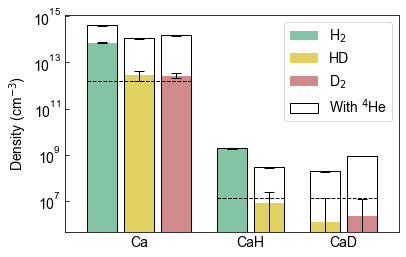

In [47]:
fig, ax = plt.subplots(figsize = (6,4))


# str_prefix = 'C:\\Users\\Hydride Sequencer\\Desktop\\CryoMolExData\\'
str_prefix = 'Y:\\CryoMolEx\\CryoMolExData\\'
cahnum = [10]
labellist = [0]
fill_list = [True]
result_list = []
result_err_list = []

for i in range(len(cahnum)):
    data = Analyzer(str_prefix, year=2024, month=6, date=27, filenum=cahnum[i], group=1)
    data.read_analog()
    data.mean_analog(channel = 0, intstart=0, intend=1)
    result = calcium657AbsToDensity(-np.mean(data.ana_mean))
    upper = calcium657AbsToDensity(np.mean(-data.ana_mean)+2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
    lower = calcium657AbsToDensity(np.mean(-data.ana_mean)-2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
    err = (upper-lower)/2
    result_list.append(result)
    result_err_list.append(err)
    ax.bar(labellist[i], result, yerr=err, width = 0.08, error_kw=dict(lw=1, capsize=5, capthick=1), color = '#82c4a3',fill=fill_list[i], label='H$_2$')

# str_prefix = 'C:\\Users\\Hydride Sequencer\\Desktop\\CryoMolExData\\'
str_prefix = 'Y:\\CryoMolEx\\CryoMolExData\\'
cahnum = [25]
labellist = [0.1]
fill_list = [True]
reslist = []
reserr = []

for i in range(len(cahnum)):
    data = Analyzer(str_prefix, year=2024, month=7, date=5, filenum=cahnum[i], group=1)
    data.read_analog()
    data.mean_analog(channel = 0, intstart=0, intend=1)
    result = calcium657AbsToDensity(-np.mean(data.ana_mean))
    upper = calcium657AbsToDensity(np.mean(-data.ana_mean)+2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
    lower = calcium657AbsToDensity(np.mean(-data.ana_mean)-2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
    err = (upper-lower)/2
    result_list.append(result)
    result_err_list.append(err)
    ax.bar(labellist[i], result, yerr=err, width = 0.08, error_kw=dict(lw=1, capsize=5, capthick=1), color = '#e1d260',fill=fill_list[i], label = 'HD')
    
# str_prefix = 'C:\\Users\\Hydride Sequencer\\Desktop\\CryoMolExData\\'
str_prefix = 'Y:\\CryoMolEx\\CryoMolExData\\'
cahnum = [18]
labellist = [0.2]
fill_list = [True]
result_list = []
result_err_list = []

for i in range(len(cahnum)):
    data = Analyzer(str_prefix, year=2024, month=6, date=27, filenum=cahnum[i], group=1)
    data.read_analog()
    data.mean_analog(channel = 0, intstart=0, intend=1)
    result = calcium657AbsToDensity(-np.mean(data.ana_mean))
    upper = calcium657AbsToDensity(np.mean(-data.ana_mean)+2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
    lower = calcium657AbsToDensity(np.mean(-data.ana_mean)-2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
    err = (upper-lower)/2
    result_list.append(result)
    result_err_list.append(err)
    ax.bar(labellist[i], result, yerr=err, width = 0.08, error_kw=dict(lw=1, capsize=5, capthick=1), color = '#d18a8b',fill=fill_list[i],label ='D$_2$')

# str_prefix = 'C:\\Users\\Hydride Sequencer\\Desktop\\CryoMolExData\\'
str_prefix = 'Y:\\CryoMolEx\\CryoMolExData\\'
cahnum = [28]
labellist = [0]
fill_list = [False]
result_list = []
result_err_list = []

for i in range(len(cahnum)):
    data = Analyzer(str_prefix, year=2024, month=6, date=27, filenum=cahnum[i], group=1)
    data.read_analog()
    data.mean_analog(channel = 0, intstart=0, intend=1)
    result = calcium657AbsToDensity(-np.mean(data.ana_mean))
    upper = calcium657AbsToDensity(np.mean(-data.ana_mean)+2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
    lower = calcium657AbsToDensity(np.mean(-data.ana_mean)-2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
    err = (upper-lower)/2
    result_list.append(result)
    result_err_list.append(err)
    ax.bar(labellist[i], result, yerr=err, width = 0.08, error_kw=dict(lw=1, capsize=5, capthick=1), color = '#82c4a3',fill=fill_list[i], label='With $^4$He')
#     ax.bar(labellist[i], result, width = 0.08, color = '#82c4a3',fill=fill_list[i])

    
# str_prefix = 'C:\\Users\\Hydride Sequencer\\Desktop\\CryoMolExData\\'
str_prefix = 'Y:\\CryoMolEx\\CryoMolExData\\'
cahnum = [19]
labellist = [0.1]
fill_list = [False]
reslist = []
reserr = []

for i in range(len(cahnum)):
    data = Analyzer(str_prefix, year=2024, month=7, date=5, filenum=cahnum[i], group=1)
    data.read_analog()
    data.mean_analog(channel = 0, intstart=0, intend=1)
    result = calcium657AbsToDensity(-np.mean(data.ana_mean))
    upper = calcium657AbsToDensity(np.mean(-data.ana_mean)+2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
    lower = calcium657AbsToDensity(np.mean(-data.ana_mean)-2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
    err = (upper-lower)/2
    result_list.append(result)
    result_err_list.append(err)
    ax.bar(labellist[i], result, yerr=err, width = 0.08, error_kw=dict(lw=1, capsize=5, capthick=1), color = '#e1d260',fill=fill_list[i])
    
# str_prefix = 'C:\\Users\\Hydride Sequencer\\Desktop\\CryoMolExData\\'
str_prefix = 'Y:\\CryoMolEx\\CryoMolExData\\'
cahnum = [23]
labellist = [0.2]
fill_list = [False]
result_list = []
result_err_list = []

for i in range(len(cahnum)):
    data = Analyzer(str_prefix, year=2024, month=6, date=27, filenum=cahnum[i], group=1)
    data.read_analog()
    data.mean_analog(channel = 0, intstart=0, intend=1)
    result = calcium657AbsToDensity(-np.mean(data.ana_mean))
    upper = calcium657AbsToDensity(np.mean(-data.ana_mean)+2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
    lower = calcium657AbsToDensity(np.mean(-data.ana_mean)-2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
    err = (upper-lower)/2
    result_list.append(result)
    result_err_list.append(err)
    ax.bar(labellist[i], result, yerr=err, width = 0.08, error_kw=dict(lw=1, capsize=5, capthick=1), color = '#d18a8b',fill=fill_list[i])



# # str_prefix = 'C:\\Users\\Hydride Sequencer\\Desktop\\CryoMolExData\\'
# str_prefix = 'Y:\\CryoMolEx\\CryoMolExData\\'
# cahnum = [10,28]
# labellist = [0.35,0.35]
# fill_list = [True,False]
# result_list = []
# result_err_list = []

# for i in range(len(cahnum)):
#     data = Analyzer(str_prefix, year=2024, month=6, date=27, filenum=cahnum[i], group=1)
#     data.read_analog()
#     data.mean_analog(channel = 1, intstart=0, intend=1)
#     result = absToDensity(-np.mean(data.ana_mean))
#     upper = absToDensity(np.mean(-data.ana_mean)+2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
#     lower = absToDensity(np.mean(-data.ana_mean)-2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
#     err = (upper-lower)/2
#     result_list.append(result)
#     result_err_list.append(err)
#     ax.bar(labellist[i], result, yerr=err, width = 0.08, error_kw=dict(lw=1, capsize=5, capthick=1), color = '#82c4a3',fill=fill_list[i])

str_prefix = 'Y:\\CryoMolEx\\CryoMolExData\\'
cahnum = [4,6]
labellist = [0.35,0.35]
fill_list = [True,False]
result_list = []
result_err_list = []

for i in range(len(cahnum)):
    data = Analyzer(str_prefix, year=2024, month=4, date=17, filenum=cahnum[i], group=1)
    data.read_analog()
    data.mean_analog(channel = 0, intstart=0, intend=1)
    result = absToDensity(-np.mean(data.ana_mean))
    upper = absToDensity(np.mean(-data.ana_mean)+2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
    lower = absToDensity(np.mean(-data.ana_mean)-2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
    err = (upper-lower)/2
    result_list.append(result)
    result_err_list.append(err)
    ax.bar(labellist[i], result, yerr=err, width = 0.08, error_kw=dict(lw=1, capsize=5, capthick=1), color = '#82c4a3',fill=fill_list[i])

# str_prefix = 'C:\\Users\\Hydride Sequencer\\Desktop\\CryoMolExData\\'
str_prefix = 'Y:\\CryoMolEx\\CryoMolExData\\'
cahnum = [52,46]
labellist = [0.45,0.45]
fill_list = [True,False]
reslist = []
reserr = []

for i in range(len(cahnum)):
    data = Analyzer(str_prefix, year=2024, month=7, date=3, filenum=cahnum[i], group=1)
    data.read_analog()
    data.mean_analog(channel = 1, intstart=0, intend=1)
    result = absToDensity(-np.mean(data.ana_mean))
    upper = absToDensity(np.mean(-data.ana_mean)+2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
    lower = absToDensity(np.mean(-data.ana_mean)-2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
    err = (upper-lower)/2
    result_list.append(result)
    result_err_list.append(err)
    ax.bar(labellist[i], result, yerr=err, width = 0.08, error_kw=dict(lw=1, capsize=5, capthick=1), color = '#e1d260', fill=fill_list[i])
    
# str_prefix = 'C:\\Users\\Hydride Sequencer\\Desktop\\CryoMolExData\\'
str_prefix = 'Y:\\CryoMolEx\\CryoMolExData\\'
cahnum = [18,19]
labellist = [0.6,0.6]
fill_list = [True,False]
reslist = []
reserr = []

for i in range(len(cahnum)):
    data = Analyzer(str_prefix, year=2024, month=7, date=5, filenum=cahnum[i], group=1)
    data.read_analog()
    data.mean_analog(channel = 1, intstart=0, intend=1)
    result = absToDensity(-np.mean(data.ana_mean))
    upper = absToDensity(np.mean(-data.ana_mean)+2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
    lower = absToDensity(np.mean(-data.ana_mean)-2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
    err = (upper-lower)/2
    result_list.append(result)
    result_err_list.append(err)
    ax.bar(labellist[i], result, yerr=err, width = 0.08, error_kw=dict(lw=1, capsize=5, capthick=1), color = '#e1d260',fill=fill_list[i])
    
# str_prefix = 'C:\\Users\\Hydride Sequencer\\Desktop\\CryoMolExData\\'
str_prefix = 'Y:\\CryoMolEx\\CryoMolExData\\'
cahnum = [18,23]
labellist = [0.7,0.7]
fill_list = [True,False]
result_list = []
result_err_list = []

for i in range(len(cahnum)):
    data = Analyzer(str_prefix, year=2024, month=6, date=27, filenum=cahnum[i], group=1)
    data.read_analog()
    data.mean_analog(channel = 1, intstart=0, intend=1)
    result = absToDensity(-np.mean(data.ana_mean))
    upper = absToDensity(np.mean(-data.ana_mean)+2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
    lower = absToDensity(np.mean(-data.ana_mean)-2*np.std(data.ana_mean)/np.sqrt(len(data.ana_mean)))
    err = (upper-lower)/2
    result_list.append(result)
    result_err_list.append(err)
    ax.bar(labellist[i], result, yerr=err, width = 0.08, error_kw=dict(lw=1, capsize=5, capthick=1), color = '#d18a8b', fill = fill_list[i])
    
# ax.axhline(y=absToDensity(0.02E-2), linestyle='--', color='black', linewidth=1)
# ax.axhline(y=calcium657AbsToDensity(0.02E-2), linestyle='-.', color='black', linewidth=1)

ax.hlines(y=calcium657AbsToDensity(0.02E-2), xmin=-0.04, xmax=0.24, colors='black', linestyles='dashed', linewidth=1)
ax.hlines(y=absToDensity(0.02E-2), xmin=0.31, xmax=0.49, colors='black', linestyles='dashed', linewidth=1)
ax.hlines(y=absToDensity(0.02E-2), xmin=0.56, xmax=0.74, colors='black', linestyles='dashed', linewidth=1)

ax.set_yscale('log')
ax.set_ylabel('Density (cm$^{-3}$)')
ax.set_xticks([0.1,0.4,0.65])
ax.set_xticklabels(['Ca','CaH','CaD'])
ax.tick_params(axis='x', which='both', length=0)
ax.legend()
plt.xlim([-0.1, 0.8])
# ax.legend(['H$_2$','HD','D$_2$','With $^4$He'])
# plt.savefig('Fig_buffer_gas_v5.pdf',bbox_inches = 'tight')